IMAGE PREPROCESSING FOR FILM RESTORATION
Loading images...
Scene shape: (1080, 2560, 3)
Template 1 shape: (29, 29, 3)
Template 2 shape: (45, 44, 3)
Template 3 shape: (34, 40, 3)

Analyzing original image quality...
Original Scene:
  Brightness: 171.83
  Contrast: 19.74
  Entropy: 5.53

Original Template 1:
  Brightness: 164.12
  Contrast: 17.56
  Entropy: 4.97

Original Template 2:
  Brightness: 164.45
  Contrast: 17.21
  Entropy: 5.04

Original Template 3:
  Brightness: 174.65
  Contrast: 16.26
  Entropy: 5.73

Preprocessing images...
Analyzing processed image quality...
Processed Scene:
  Brightness: 123.53
  Contrast: 66.77
  Entropy: 7.10

Processed Template 1:
  Brightness: 130.90
  Contrast: 104.10
  Entropy: 3.62

Processed Template 2:
  Brightness: 115.69
  Contrast: 91.00
  Entropy: 4.82

Processed Template 3:
  Brightness: 132.30
  Contrast: 98.69
  Entropy: 5.56

Visualizing preprocessing results...


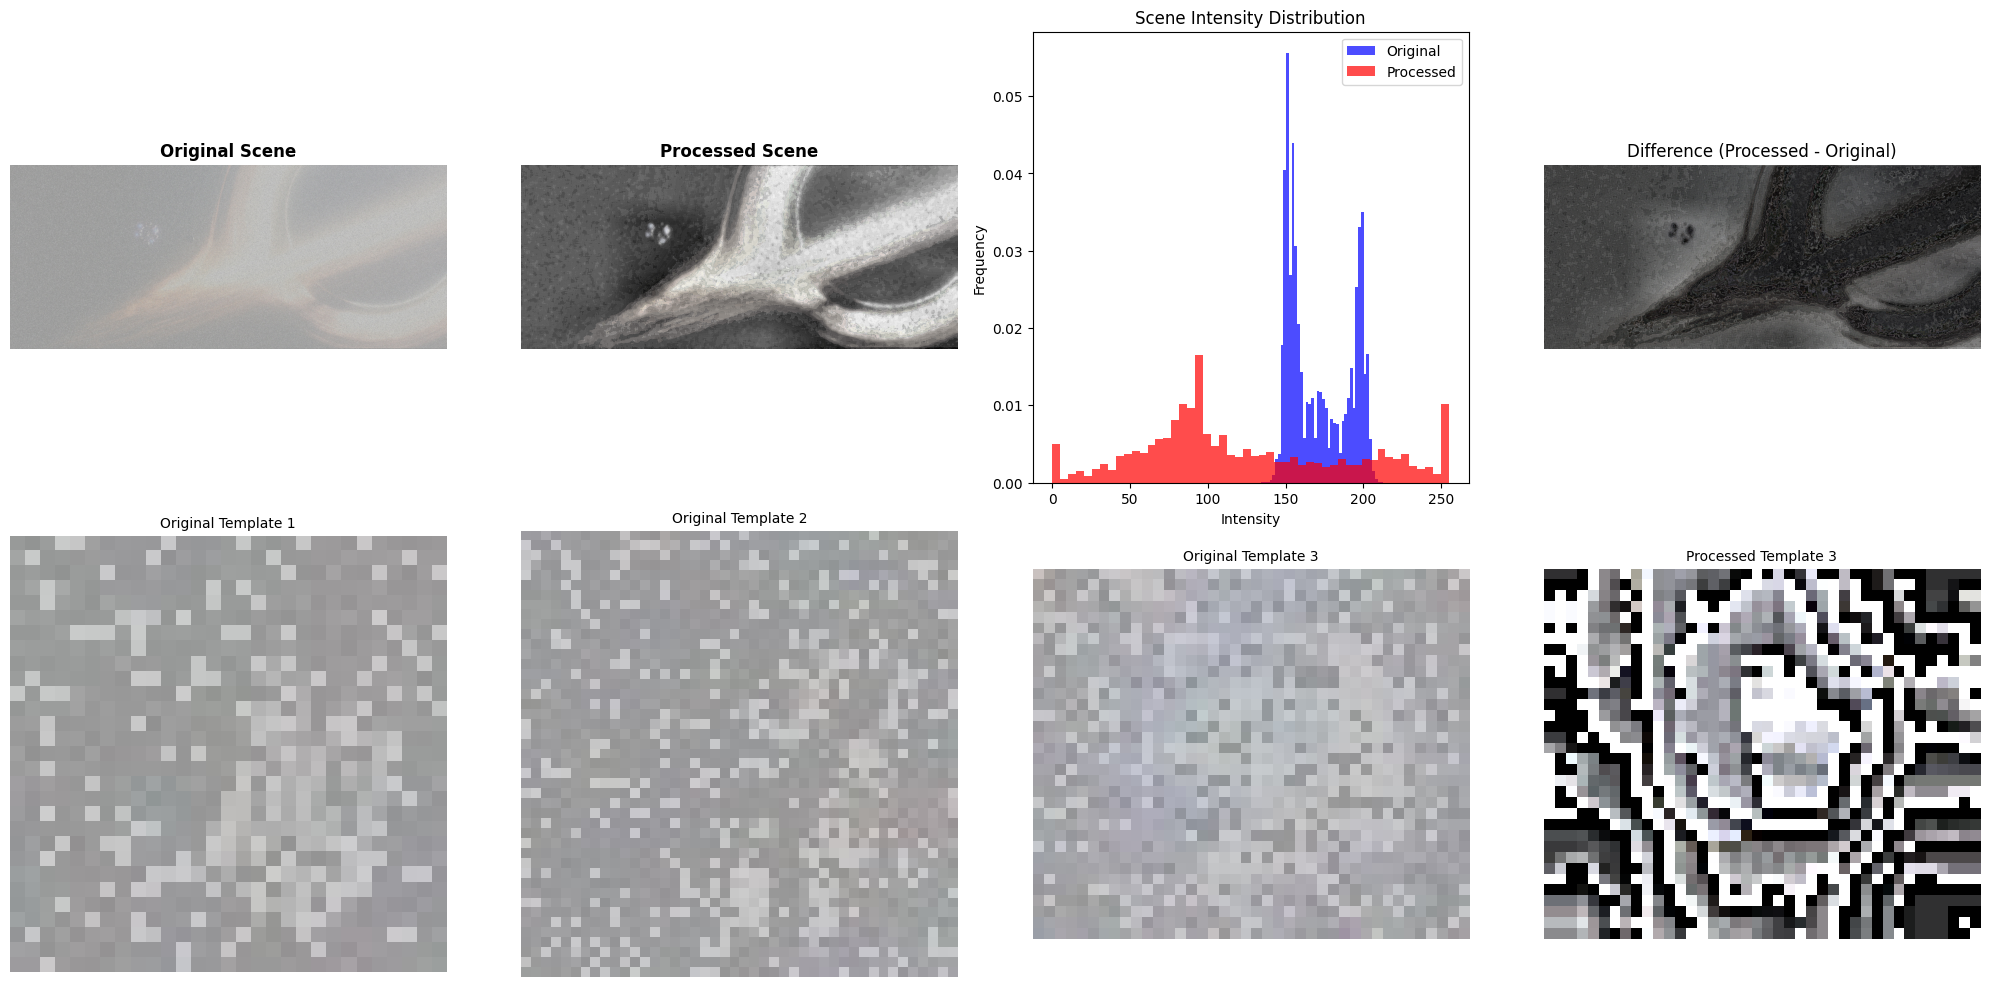


Preprocessing completed!
Saved files:
- processed_scene.jpg
- processed_template_1.jpg
- processed_template_2.jpg
- processed_template_3.jpg
- preprocessing_results.jpg


In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def load_images():
    """Load the scene and template images"""
    print("Loading images...")
    
    scene_path = 'data/pre_img.jpg'
    template_paths = [
        'data/pre_template_001.jpg',
        'data/pre_template_002.jpg', 
        'data/pre_template_003.jpg'
    ]
    
    # Load scene image
    scene = cv2.imread(scene_path)
    if scene is None:
        raise FileNotFoundError(f"Scene image not found at {scene_path}")
    
    # Load template images
    templates = []
    for i, template_path in enumerate(template_paths):
        template = cv2.imread(template_path)
        if template is None:
            raise FileNotFoundError(f"Template {i+1} not found at {template_path}")
        templates.append(template)
    
    # Convert from BGR to RGB for processing
    scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
    templates = [cv2.cvtColor(t, cv2.COLOR_BGR2RGB) for t in templates]
    
    print(f"Scene shape: {scene.shape}")
    for i, template in enumerate(templates):
        print(f"Template {i+1} shape: {template.shape}")
    
    return scene, templates

def preprocess_image(image, denoise_strength=15, contrast_clip=2.0):
    """
    Preprocess image: denoise, enhance contrast, and adjust brightness
    """
    # Convert to float for processing
    img_float = image.astype(np.float32) / 255.0
    
    # 1. DENOISING: Remove Gaussian noise while preserving edges
    denoised = cv2.fastNlMeansDenoisingColored(
        (img_float * 255).astype(np.uint8), 
        None,
        denoise_strength,           # h: filter strength
        denoise_strength * 0.8,     # hColor: color component filter strength
        7,                          # templateWindowSize
        21                          # searchWindowSize
    )
    
    # 2. CONTRAST ENHANCEMENT: Use CLAHE for adaptive contrast adjustment
    # Convert to LAB color space
    lab = cv2.cvtColor(denoised, cv2.COLOR_RGB2LAB)
    l_channel, a, b = cv2.split(lab)
    
    # Apply CLAHE to L channel (lightness)
    clahe = cv2.createCLAHE(
        clipLimit=contrast_clip,    # Contrast limit for histogram equalization
        tileGridSize=(8, 8)         # Size of grid for histogram equalization
    )
    l_channel = clahe.apply(l_channel)
    
    # Merge channels and convert back to RGB
    lab = cv2.merge([l_channel, a, b])
    contrast_enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    # 3. BRIGHTNESS NORMALIZATION: Adjust overall brightness levels
    # Convert to HSV for brightness adjustment
    hsv = cv2.cvtColor(contrast_enhanced, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    
    # Normalize value channel (brightness)
    v = cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX)
    
    # Merge back and convert to RGB
    hsv = cv2.merge([h, s, v])
    brightness_normalized = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    # 4. MILD SHARPENING: Enhance edges for better feature detection
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    sharpened = cv2.filter2D(brightness_normalized, -1, kernel)
    
    return sharpened

def visualize_preprocessing_results(original_scene, processed_scene, original_templates, processed_templates):
    """Visualize the preprocessing results"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Original scene
    axes[0, 0].imshow(original_scene)
    axes[0, 0].set_title('Original Scene', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Processed scene
    axes[0, 1].imshow(processed_scene)
    axes[0, 1].set_title('Processed Scene', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Histogram comparison for scene
    axes[0, 2].hist(original_scene.ravel(), bins=50, alpha=0.7, color='blue', 
                   label='Original', density=True)
    axes[0, 2].hist(processed_scene.ravel(), bins=50, alpha=0.7, color='red', 
                   label='Processed', density=True)
    axes[0, 2].set_title('Scene Intensity Distribution', fontsize=12)
    axes[0, 2].legend()
    axes[0, 2].set_xlabel('Intensity')
    axes[0, 2].set_ylabel('Frequency')
    
    # Difference image
    diff = cv2.absdiff(original_scene, processed_scene)
    axes[0, 3].imshow(diff, cmap='hot')
    axes[0, 3].set_title('Difference (Processed - Original)', fontsize=12)
    axes[0, 3].axis('off')
    
    # Templates comparison
    for i in range(3):
        if i < len(original_templates):
            axes[1, i].imshow(original_templates[i])
            axes[1, i].set_title(f'Original Template {i+1}', fontsize=10)
            axes[1, i].axis('off')
            
            axes[1, i+1].imshow(processed_templates[i])
            axes[1, i+1].set_title(f'Processed Template {i+1}', fontsize=10)
            axes[1, i+1].axis('off')
    
    plt.tight_layout()
    plt.savefig('output-q3/preprocessing_results.jpg', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_image_quality(image, name):
    """Analyze image quality metrics"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Calculate metrics
    brightness = np.mean(gray)
    contrast = np.std(gray)
    entropy = calculate_entropy(gray)
    
    print(f"{name}:")
    print(f"  Brightness: {brightness:.2f}")
    print(f"  Contrast: {contrast:.2f}")
    print(f"  Entropy: {entropy:.2f}")
    print()

def calculate_entropy(image):
    """Calculate image entropy (measure of information content)"""
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist / hist.sum()
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    return entropy

def main_preprocessing():
    """Main function for preprocessing step"""
    print("=" * 60)
    print("IMAGE PREPROCESSING FOR FILM RESTORATION")
    print("=" * 60)
    
    # Load images
    scene, templates = load_images()
    
    print("\nAnalyzing original image quality...")
    analyze_image_quality(scene, "Original Scene")
    for i, template in enumerate(templates):
        analyze_image_quality(template, f"Original Template {i+1}")
    
    print("Preprocessing images...")
    # Apply identical preprocessing to scene and templates
    processed_scene = preprocess_image(scene)
    processed_templates = [preprocess_image(t) for t in templates]
    
    print("Analyzing processed image quality...")
    analyze_image_quality(processed_scene, "Processed Scene")
    for i, template in enumerate(processed_templates):
        analyze_image_quality(template, f"Processed Template {i+1}")
    
    print("Visualizing preprocessing results...")
    visualize_preprocessing_results(scene, processed_scene, templates, processed_templates)
    
    # Save processed images
    cv2.imwrite('output-q3/processed_scene.jpg', cv2.cvtColor(processed_scene, cv2.COLOR_RGB2BGR))
    for i, template in enumerate(processed_templates):
        cv2.imwrite(f'output-q3/processed_template_{i+1}.jpg', cv2.cvtColor(template, cv2.COLOR_RGB2BGR))
    
    print("\nPreprocessing completed!")
    print("Saved files:")
    print("- processed_scene.jpg")
    print("- processed_template_1.jpg")
    print("- processed_template_2.jpg")
    print("- processed_template_3.jpg")
    print("- preprocessing_results.jpg")
    
    return processed_scene, processed_templates

if __name__ == "__main__":
    processed_scene, processed_templates = main_preprocessing()

Loaded preprocessed images successfully!
TEMPLATE MATCHING USING CROSS-CORRELATION
Performing template matching...

Matching Template 1...
  No matches found even at lowest threshold 0.3
  Found 3 matches at threshold 0.2

Matching Template 2...
  No matches found even at lowest threshold 0.3

Matching Template 3...
  No matches found even at lowest threshold 0.3
  Found 1 matches at threshold 0.2

Visualizing results...


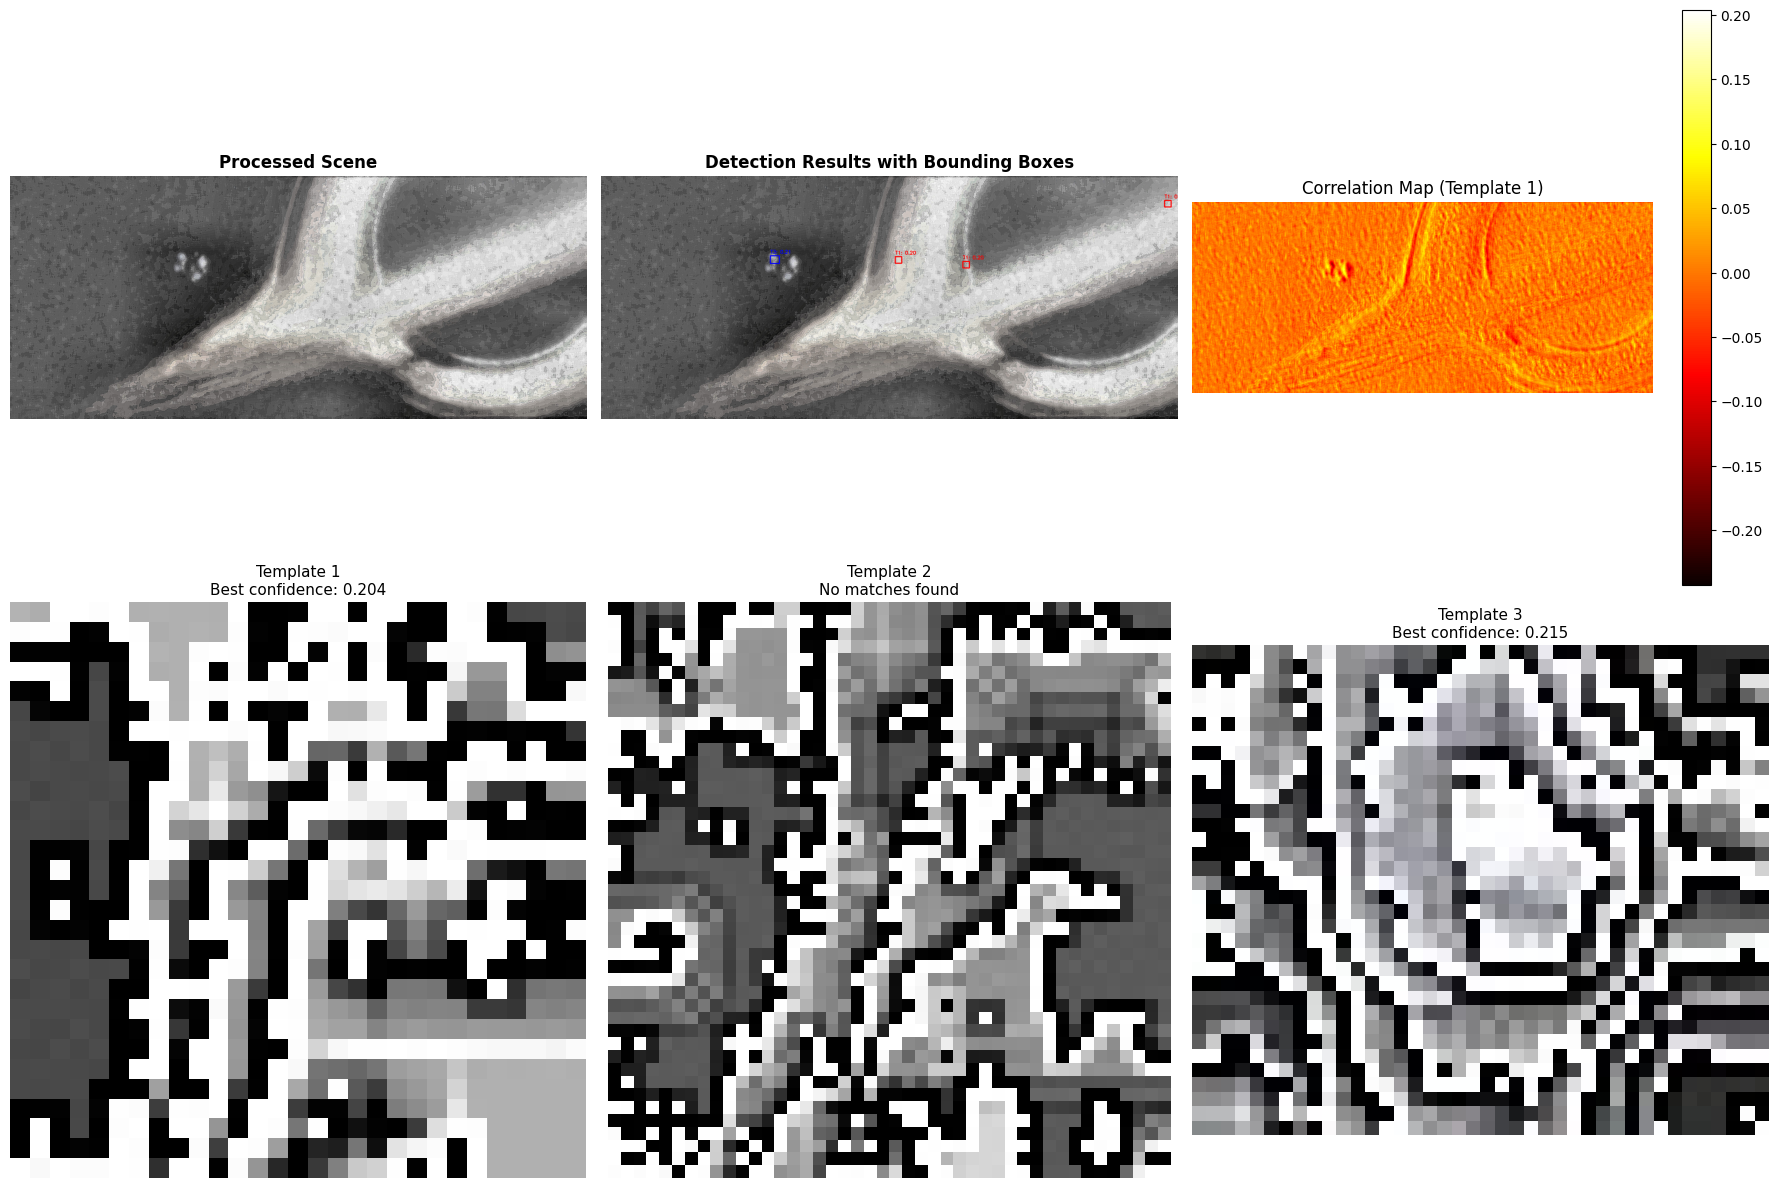


Analyzing matching quality...
TEMPLATE MATCHING QUALITY ANALYSIS

Template 1:
------------------------------
  Match 1:
    Position: (2500, 112)
    Size: 29×29
    Confidence: 0.204
    MSE: 15356.46
    SSIM: 0.143
  Match 2:
    Position: (1305, 361)
    Size: 29×29
    Confidence: 0.201
    MSE: 16400.11
    SSIM: 0.122
  Match 3:
    Position: (1605, 382)
    Size: 29×29
    Confidence: 0.201
    MSE: 13013.56
    SSIM: 0.176

Template 2:
------------------------------
  No matches found

Template 3:
------------------------------
  Match 1:
    Position: (751, 357)
    Size: 40×34
    Confidence: 0.215
    MSE: 10961.65
    SSIM: 0.195

FINAL DETECTION RESULTS

Template 1:
  Match 1:
    Bounding Box: (x=2500, y=112, width=29, height=29)
    Confidence: 0.204
  Match 2:
    Bounding Box: (x=1305, y=361, width=29, height=29)
    Confidence: 0.201
  Match 3:
    Bounding Box: (x=1605, y=382, width=29, height=29)
    Confidence: 0.201

Template 2:
  No matches found

Template 3:
 

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage

def template_matching_cross_correlation(scene, template, method=cv2.TM_CCOEFF_NORMED):
    """
    Perform template matching using cross-correlation
    Returns: result matrix, best match location, confidence score
    """
    # Convert to grayscale for matching (more robust than color matching)
    scene_gray = cv2.cvtColor(scene, cv2.COLOR_RGB2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
    
    # Perform template matching
    result = cv2.matchTemplate(scene_gray, template_gray, method)
    
    # Find the best match location
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    
    # For normalized cross-correlation, higher values are better
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
        confidence = 1 - min_val
    else:
        top_left = max_loc
        confidence = max_val
    
    return result, top_left, confidence

def find_multiple_matches(scene, template, threshold=0.7, method=cv2.TM_CCOEFF_NORMED):
    """
    Find multiple matches of the template using thresholding
    """
    scene_gray = cv2.cvtColor(scene, cv2.COLOR_RGB2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
    
    # Perform template matching
    result = cv2.matchTemplate(scene_gray, template_gray, method)
    
    # Get all locations above threshold
    locations = np.where(result >= threshold)
    
    matches = []
    for pt in zip(*locations[::-1]):  # Switch x and y coordinates
        matches.append({
            'top_left': pt,
            'bottom_right': (pt[0] + template_gray.shape[1], pt[1] + template_gray.shape[0]),
            'confidence': result[pt[1], pt[0]]
        })
    
    # Apply non-maximum suppression to avoid duplicate detections
    matches = non_max_suppression(matches)
    
    return matches

def non_max_suppression(matches, overlap_threshold=0.3):
    """
    Apply non-maximum suppression to remove overlapping boxes
    """
    if len(matches) == 0:
        return []
    
    # Convert to numpy array for easier processing
    boxes = np.array([[
        m['top_left'][0], 
        m['top_left'][1], 
        m['bottom_right'][0] - m['top_left'][0],
        m['bottom_right'][1] - m['top_left'][1],
        m['confidence']
    ] for m in matches])
    
    # Apply NMS
    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]
    scores = boxes[:, 4]
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)[::-1]  # Sort in descending order
    
    while len(idxs) > 0:
        i = idxs[0]
        pick.append(i)
        
        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])
        
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        overlap = (w * h) / area[idxs[1:]]
        
        idxs = idxs[np.where(overlap <= overlap_threshold)[0] + 1]
    
    return [matches[i] for i in pick]

def visualize_template_matching(scene, templates, all_matches, correlation_maps=None):
    """
    Visualize template matching results
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Show original scene
    axes[0, 0].imshow(scene)
    axes[0, 0].set_title('Processed Scene', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Show result with bounding boxes
    result_image = scene.copy()
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Red, Green, Blue
    
    for i, matches in enumerate(all_matches):
        for match in matches:
            cv2.rectangle(result_image, match['top_left'], match['bottom_right'], 
                         colors[i], 3)
            cv2.putText(result_image, f'T{i+1}: {match["confidence"]:.2f}', 
                       (match['top_left'][0], match['top_left'][1]-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, colors[i], 2)
    
    axes[0, 1].imshow(result_image)
    axes[0, 1].set_title('Detection Results with Bounding Boxes', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Show correlation maps if provided
    if correlation_maps and len(correlation_maps) > 0:
        im = axes[0, 2].imshow(correlation_maps[0], cmap='hot')
        axes[0, 2].set_title('Correlation Map (Template 1)', fontsize=12)
        axes[0, 2].axis('off')
        plt.colorbar(im, ax=axes[0, 2])
    
    # Show templates and their best matches
    for i, template in enumerate(templates[:3]):
        axes[1, i].imshow(template)
        if i < len(all_matches) and all_matches[i]:
            best_match = max(all_matches[i], key=lambda x: x['confidence'])
            title = f'Template {i+1}\nBest confidence: {best_match["confidence"]:.3f}'
        else:
            title = f'Template {i+1}\nNo matches found'
        axes[1, i].set_title(title, fontsize=11)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('output-q3/template_matching_results.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    
    return result_image

def analyze_matching_quality(scene, templates, all_matches):
    """
    Analyze the quality of template matching results
    """
    print("=" * 60)
    print("TEMPLATE MATCHING QUALITY ANALYSIS")
    print("=" * 60)
    
    scene_gray = cv2.cvtColor(scene, cv2.COLOR_RGB2GRAY)
    
    for i, (template, matches) in enumerate(zip(templates, all_matches)):
        template_gray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
        
        print(f"\nTemplate {i+1}:")
        print("-" * 30)
        
        if not matches:
            print("  No matches found")
            continue
        
        for j, match in enumerate(matches):
            # Extract ROI from scene
            x1, y1 = match['top_left']
            x2, y2 = match['bottom_right']
            roi = scene_gray[y1:y2, x1:x2]
            
            # Calculate additional quality metrics
            if roi.shape[0] > 0 and roi.shape[1] > 0:
                # Resize ROI to match template size if needed
                if roi.shape != template_gray.shape:
                    roi = cv2.resize(roi, (template_gray.shape[1], template_gray.shape[0]))
                
                # Calculate MSE (Mean Squared Error)
                mse = np.mean((template_gray.astype(float) - roi.astype(float)) ** 2)
                
                # Calculate SSIM (Structural Similarity) - simplified version
                mean_template = np.mean(template_gray)
                mean_roi = np.mean(roi)
                std_template = np.std(template_gray)
                std_roi = np.std(roi)
                covariance = np.cov(template_gray.flatten(), roi.flatten())[0, 1]
                ssim = ((2 * mean_template * mean_roi) * (2 * covariance)) / \
                       ((mean_template**2 + mean_roi**2) * (std_template**2 + std_roi**2))
                
                print(f"  Match {j+1}:")
                print(f"    Position: ({x1}, {y1})")
                print(f"    Size: {x2-x1}×{y2-y1}")
                print(f"    Confidence: {match['confidence']:.3f}")
                print(f"    MSE: {mse:.2f}")
                print(f"    SSIM: {ssim:.3f}")
            else:
                print(f"  Match {j+1}: Invalid ROI dimensions")

def main_template_matching(processed_scene, processed_templates):
    """
    Main function for template matching step
    """
    print("=" * 60)
    print("TEMPLATE MATCHING USING CROSS-CORRELATION")
    print("=" * 60)
    
    # Try multiple threshold values to ensure we find matches
    thresholds = [0.6, 0.5, 0.4, 0.3]
    all_matches = []
    correlation_maps = []
    
    print("Performing template matching...")
    for i, template in enumerate(processed_templates):
        print(f"\nMatching Template {i+1}...")
        
        best_matches = []
        best_threshold = None
        
        # Try different thresholds
        for threshold in thresholds:
            matches = find_multiple_matches(processed_scene, template, threshold=threshold)
            if matches:
                best_matches = matches
                best_threshold = threshold
                print(f"  Threshold {threshold}: Found {len(matches)} matches")
                break
        
        if not best_matches:
            print(f"  No matches found even at lowest threshold {thresholds[-1]}")
            # Try with even lower threshold as last resort
            matches = find_multiple_matches(processed_scene, template, threshold=0.2)
            if matches:
                best_matches = matches
                best_threshold = 0.2
                print(f"  Found {len(matches)} matches at threshold 0.2")
        
        all_matches.append(best_matches)
        
        # Store correlation map for visualization
        if best_matches:
            result_map, _, _ = template_matching_cross_correlation(processed_scene, template)
            correlation_maps.append(result_map)
    
    print("\nVisualizing results...")
    result_image = visualize_template_matching(processed_scene, processed_templates, all_matches, correlation_maps)
    
    print("\nAnalyzing matching quality...")
    analyze_matching_quality(processed_scene, processed_templates, all_matches)
    
    # Save final result
    cv2.imwrite('output-q3/final_detection_result.jpg', cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))
    
    print("\n" + "=" * 60)
    print("FINAL DETECTION RESULTS")
    print("=" * 60)
    
    for i, matches in enumerate(all_matches):
        print(f"\nTemplate {i+1}:")
        if not matches:
            print("  No matches found")
            continue
        
        for j, match in enumerate(matches):
            x, y = match['top_left']
            w = match['bottom_right'][0] - x
            h = match['bottom_right'][1] - y
            print(f"  Match {j+1}:")
            print(f"    Bounding Box: (x={x}, y={y}, width={w}, height={h})")
            print(f"    Confidence: {match['confidence']:.3f}")
    
    return all_matches

# Run the template matching
if __name__ == "__main__":
    # Load the preprocessed images (from previous step)
    try:
        processed_scene = cv2.imread('output-q3/processed_scene.jpg')
        processed_scene = cv2.cvtColor(processed_scene, cv2.COLOR_BGR2RGB)
        
        processed_templates = []
        for i in range(1, 4):
            template = cv2.imread(f'output-q3/processed_template_{i}.jpg')
            template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
            processed_templates.append(template)
        
        print("Loaded preprocessed images successfully!")
        
    except Exception as e:
        print(f"Error loading preprocessed images: {e}")
        print("Please run the preprocessing step first.")
        exit()
    
    # Perform template matching
    matches = main_template_matching(processed_scene, processed_templates)